# Dataset

In [ ]:
import torch, torchvision
from step_1.datasets import CitySegmentation

In [ ]:
dataset = CitySegmentation(root='/home/simone/KD/CIRKD/data/Cityscapes/', split='val', crop_size=0)
x, y, n = dataset[0]
x.shape, y.shape, n

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=None)

In [ ]:
for i, l, n in train_loader:
    print(i.shape, l.shape, n)
    break

# Model

In [ ]:
import requests

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import torch
from transformers import (SamModel, SamProcessor)

### Visualization Tools

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(6,6))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

### Load model

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# Sparse SAM
# sparse = SamModel.from_pretrained("bin/90/").cuda().eval()

### Get Input Image

In [ ]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
# plt.imshow(raw_image)
# plt.show()

### Run Inference with Prompt

In [ ]:
input_points = [[[450, 600]]]
# show_points_on_image(raw_image, input_points[0])

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])


inputs.pop("pixel_values", None) # pixel_values are no more needed
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

### Decode Output

In [ ]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks, scores)

In [ ]:
plt.imshow(masks.squeeze()[scores.argmax()])
plt.show()

# Outputs

In [ ]:
import random

In [ ]:
def get_output_masks(processor, model, img, input_points, device):
    inputs = processor(i, input_points=input_points, return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
    inputs.pop("pixel_values", None) # pixel_values are no more needed
    inputs.update({"image_embeddings": image_embeddings})
    with torch.no_grad():
        outputs = model(**inputs)
    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
    scores = outputs.iou_scores
    return masks, scores
    
def get_input_point(l):
    x_v, y_v = np.where(l[0] >= 0)
    r = random.randint(0,len(x_v))
    x, y = x_v[r], y_v[r]
    return [[[y,x]]], l[0][x,y]

In [ ]:
def get_masks():

    name_list, mask_list, score_list, point_list, point_class_list = [], [], [], [], []
    for i, l, n in train_loader:
        
        input_points, point_class = get_input_point(l)
        # show_points_on_image(i[0], input_points[0])

        masks, scores = get_output_masks(processor, model, i, input_points, device)
        # show_masks_on_image(i[0], masks, scores)  
        
        name_list.append(str(n[0]))
        mask_list.append(masks.squeeze()[scores.argmax()].cpu().detach().numpy())
        score_list.append(float(scores.max().cpu().detach().numpy()))
        point_list.append(input_points[0][0])
        point_class_list.append(int(point_class.cpu().detach().numpy()))

    return name_list, point_list, point_class_list, mask_list, score_list

In [ ]:
name, point, point_class, mask, score = get_masks()
name[0], point[0], point_class[0], mask[0], score[0]

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({'name': name, 'point': point, 'class': point_class, 'mask': mask, 'score': score})

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.hist(column='class')

In [ ]:
df[['name', 'point', 'class']].to_pickle("results/cs_prompts.pkl")

In [ ]:
df[['name', 'point', 'class']]

In [ ]:
df = pd.read_pickle("results/cityscapes_prompts.pkl")

In [ ]:
df[df['name']=='munster_000000_000019_leftImg8bit.png'][['point', 'class']].values[0][1]

# Metrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_0 = pd.read_pickle("results/cityscapes_SAM_0.pkl")
df_10 = pd.read_pickle("results/cityscapes_SAM_10.pkl")
df_50 = pd.read_pickle("results/cityscapes_SAM_50.pkl")
df_90 = pd.read_pickle("results/cityscapes_SAM_90.pkl")
df_75 = pd.read_pickle("results/cityscapes_SAM_75.pkl")
df_80 = pd.read_pickle("results/cityscapes_SAM_80.pkl")

In [4]:
CLASSES = [
    'Road',         # 7
    'Sidewalk',     # 8
    'Building',     # 11
    'Wall',         # 12
    'Fence',        # 13
    'Pole',         # 17
    'Traffic Light',# 19
    'Traffic Sign', # 20
    'Vegetation',   # 21
    'Terrain',      # 22
    'Sky',          # 23
    'Person',       # 24
    'Rider',        # 25
    'Car',          # 26
    'Truck',        # 27
    'Bus',          # 28
    'Train',        # 31
    'Motorcycle',   # 32
    'Bicycle',      # 33
    # 'Void'         # -1, 0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30
    ]

def calculate_metrics(target, pred, eps=1e-5, verbose=False):

    if verbose:
        plt.subplot(1, 2, 1)
        plt.imshow(target)
        plt.subplot(1, 2, 2)
        plt.imshow(pred)
        plt.show()

    output = np.reshape(pred, -1)
    target = np.reshape(target, -1)

    tp = np.sum(output * target)  # TP (Intersection)
    un = np.sum(output + target)  # Union
    fp = np.sum(output * (~target))  # FP
    fn = np.sum((~output) * target)  # FN
    tn = np.sum((~output) * (~target))  # TN

    iou = (tp + eps) / (un + eps)
    pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    specificity = (tn + eps) / (tn + fp + eps)

    if verbose:
        print(f"IoU: {iou:.4f}, Pixel Acc: {pixel_acc:.4f}, Dice: {dice:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")

    return iou, pixel_acc, dice, precision, specificity, recall

In [ ]:
idx = 2
s_0 = df_0.loc[idx]
s_50 = df_50.loc[idx]

c = s_0['class']
print(f"Class: {CLASSES[c]} [{c}]")
print(f"Prompt: {s_0['prompt']}")

print(f"Score: {s_0['score']:.4f}, {s_50['score']:.4f}")

i, a, d, p, r, s = calculate_metrics(s_0['mask'], s_50['mask'], verbose=True)
print(f"Name: {s_0['name']}")


In [ ]:
for j, (i, l, n) in enumerate(train_loader):
    if j == idx:
        break

In [ ]:
show_points_on_image(l[0], [[s_0['prompt'][0], s_0['prompt'][1]]])
show_points_on_image(i[0], [[s_0['prompt'][0], s_0['prompt'][1]]])
show_points_on_image(s_0['mask'], [[s_0['prompt'][0], s_0['prompt'][1]]])

l[0][s_0['prompt'][1], s_0['prompt'][0]]

In [29]:
def get_analytics(target_df, pred_df):
    metrics = {k: [] for k in ['name', 'prompt', 'class', 'score', 'score_diff', 'mask_size', 'mask_size_diff',  'iou', 'pixel_acc', 'dice', 'precision', 'recall', 'specificity']}
    for i in range(len(target_df)):
        target = target_df.loc[i]
        pred = pred_df.loc[i]

        iou, pixel_acc, dice, precision, specificity, recall = calculate_metrics(target['mask'], pred['mask'])
        
        metrics['name'].append(target['name'])
        metrics['prompt'].append(target['prompt'])
        metrics['class'].append(target['class'])
        metrics['score'].append(pred['score'])
        metrics['score_diff'].append((pred['score'] - target['score']) / (target['score'] + 1e-5))
        p_size = np.mean(pred['mask'].astype('float'))
        t_size = np.mean(target['mask'].astype('float'))
        metrics['mask_size'].append(p_size)
        metrics['mask_size_diff'].append((p_size - t_size) / (t_size + 1e-3))
        metrics['iou'].append(iou)
        metrics['pixel_acc'].append(pixel_acc)
        metrics['dice'].append(dice)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['specificity'].append(specificity)
    
    return pd.DataFrame(metrics)

In [30]:
df = get_analytics(df_0, df_90)

In [31]:
df.head()

,name,prompt,class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity
0,munster_000021_000019_leftImg8bit.png,"[1854, 185]",2,0.940336,-0.030423,0.001593,0.044371,0.917063,0.999867,0.956737,0.923653,0.992280,0.999878
1,munster_000106_000019_leftImg8bit.png,"[921, 572]",0,1.021307,0.019846,0.457963,0.347286,0.728039,0.874469,0.842618,0.733782,0.989364,0.815371
2,munster_000086_000019_leftImg8bit.png,"[1857, 64]",2,0.902333,-0.099011,0.574501,9.905883,0.090113,0.477269,0.165327,0.090113,1.000000,0.448730
3,munster_000131_000019_leftImg8bit.png,"[997, 303]",10,0.956597,-0.036358,0.042014,-0.006771,0.966560,0.998566,0.982995,0.986426,0.979589,0.999405
4,munster_000166_000019_leftImg8bit.png,"[2000, 916]",0,0.986762,-0.009986,0.490418,0.092436,0.907601,0.954505,0.951563,0.911222,0.995640,0.921007


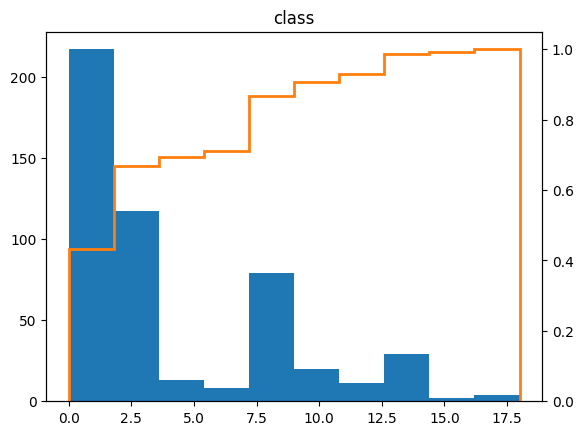

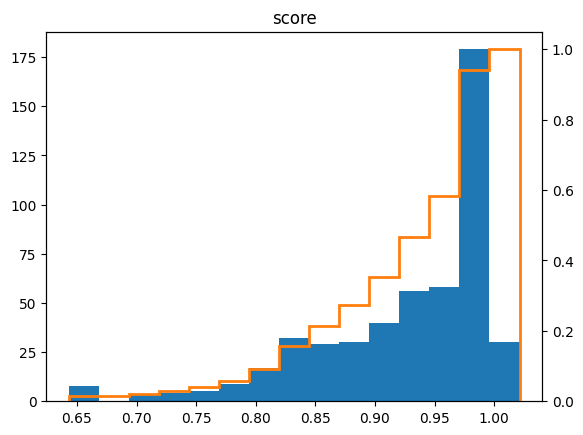

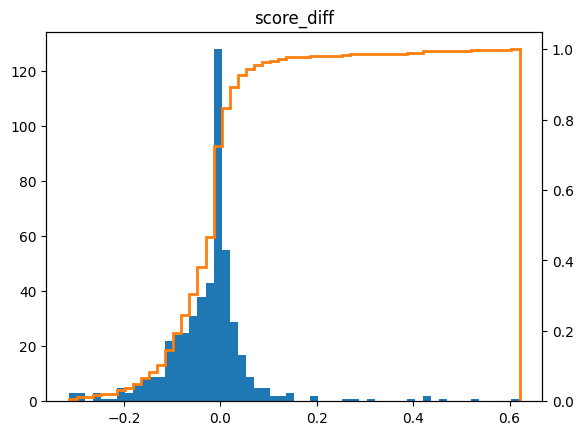

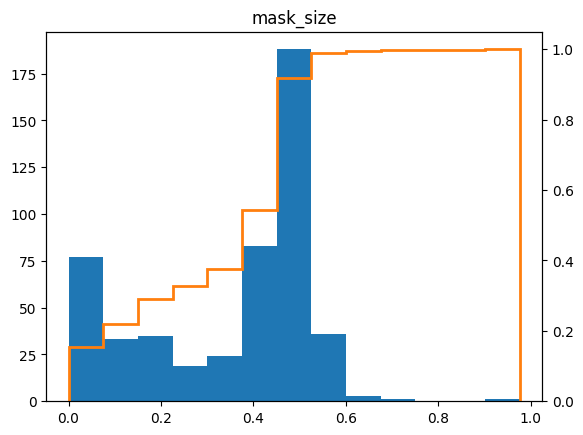

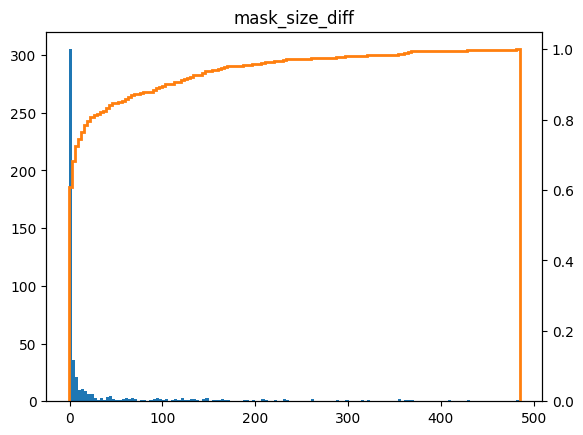

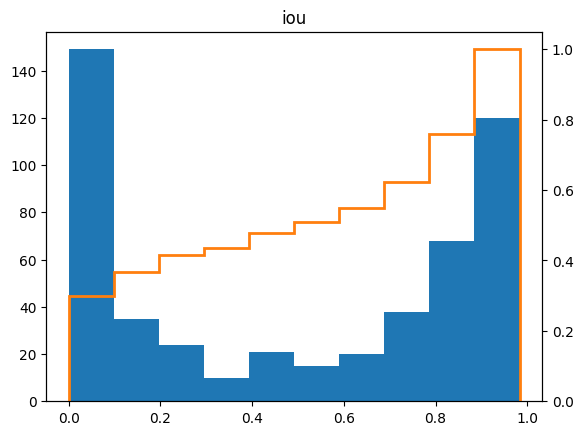

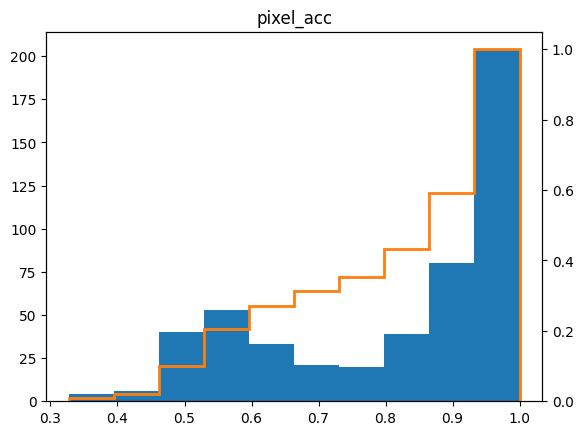

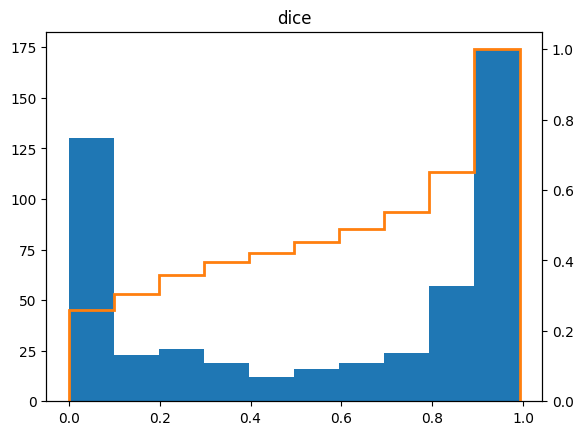

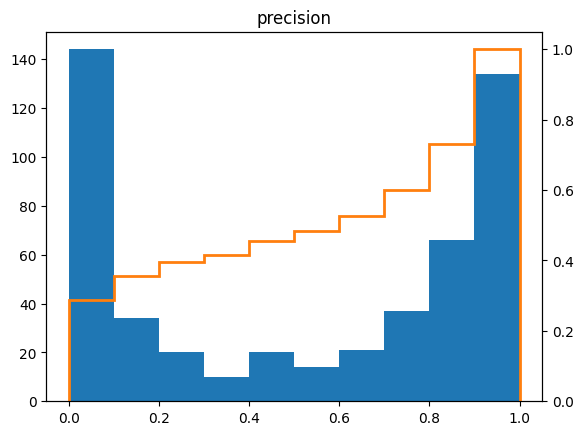

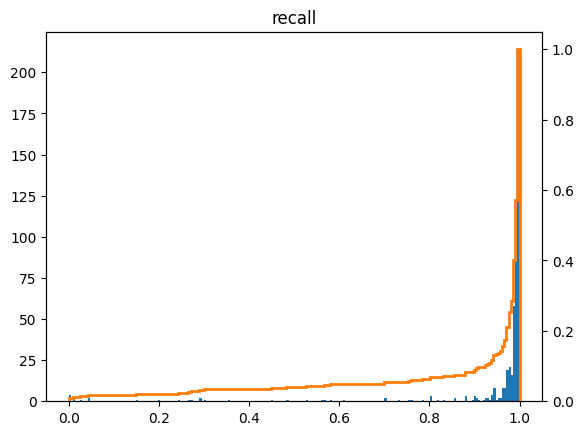

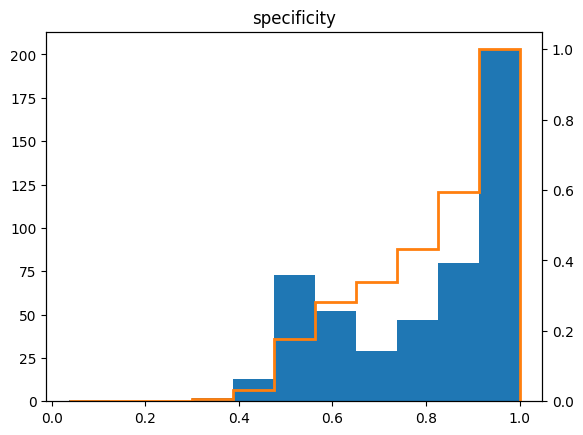

In [32]:
for k in ['class', 'score', 'score_diff', 'mask_size', 'mask_size_diff',  'iou', 'pixel_acc', 'dice', 'precision', 'recall', 'specificity']:
    s = pd.Series(df[k])
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    n, bins, patches = ax.hist(s, bins='auto')
    n, bins, patches = ax2.hist(s, cumulative=True, histtype='step', bins='auto', color='tab:orange', linewidth=2, density=True)
    plt.title(k)
    plt.show()